In [1]:
import numpy as np
from scipy.stats import ttest_ind, ttest_rel
from matplotlib import pyplot as plt
import seaborn as sns
import random
from tqdm.notebook import tqdm

# Comparing two metrics

First, we generate two synthetic measurements.
One is true + a lot of noise; one is true + very little noise.

We see that the metric with less noise tends to produce much more accurate preferences.

In [93]:
true_scores = np.random.random(size=(500))
difficulty_multiplier = np.random.random(size=(500))

a_noise = ((np.random.random(size=(500)) - .5) / 6)
b_noise = ((np.random.random(size=(500)) - .5) / 5)
a_scores = true_scores + (a_noise * (1/difficulty_multiplier))
b_scores = true_scores + (b_noise * (1/difficulty_multiplier))

def prefs(xs):
    res = []
    for i in xs:
        for j in xs:
            if i == j:
                res.append(0)
            if i > j:
                res.append(1)
            if i < j:
                res.append(-1)
    return res

true_prefs = prefs(true_scores)
a_prefs = prefs(a_scores)
b_prefs = prefs(b_scores)

a_acc = [1 if x == y else 0 for x, y in zip(true_prefs, a_prefs)]
b_acc = [1 if x == y else 0 for x, y in zip(true_prefs, b_prefs)]
print("Metric a accuracy", np.mean(a_acc))
print("Metric b accuracy", np.mean(b_acc))

Metric a accuracy 0.834184
Metric b accuracy 0.804056


## Bootstrapping over the preferences

One way to estimate our uncertainty is to bootstrap the preference correctness.

So what I do is I subsample each set of preference correctnesses.

  0%|          | 0/100 [00:00<?, ?it/s]

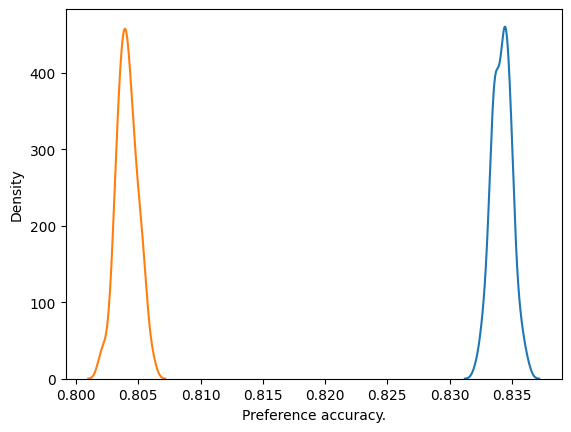

Ttest_indResult(statistic=261.05906040936014, pvalue=3.051604650668446e-253)


In [94]:
n_trials = 100
xs = []
ys = []
for _ in tqdm(range(n_trials)):
    a_subsample = random.choices(a_acc, k=len(a_acc))
    b_subsample = random.choices(b_acc, k=len(b_acc))
    xs.append(np.mean(a_subsample))
    ys.append(np.mean(b_subsample))

sns.kdeplot(xs)
sns.kdeplot(ys)
plt.xlabel("Preference accuracy.")
plt.show()
print(ttest_ind(xs, ys))

## Bootstrapping over the data

But wait... each datapoint is probably still getting represented many times in this dataset, it's just that bootstrapping filters out some % of the comparisons.

What if we bootstrap over the data itself, and then compute the pairwise preferences?

  0%|          | 0/100 [00:00<?, ?it/s]

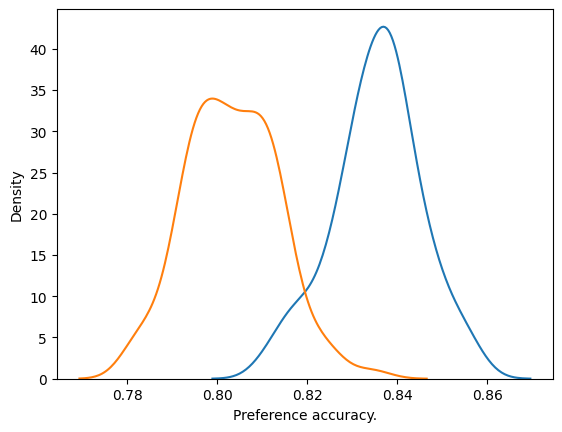

Ttest_indResult(statistic=22.87999953654389, pvalue=1.685363865238354e-57)


In [95]:
n_trials = 100
xs = []
ys = []
for _ in tqdm(range(n_trials)):
    idxs = random.choices(list(range(true_scores.shape[0])), k=true_scores.shape[0])
    true_sub = true_scores[idxs]
    a_sub = a_scores[idxs]
    b_sub = b_scores[idxs]

    true_prefs = prefs(true_sub)
    a_prefs = prefs(a_sub)
    b_prefs = prefs(b_sub)

    a_acc = [1 if x == y else 0 for x, y in zip(true_prefs, a_prefs)]
    b_acc = [1 if x == y else 0 for x, y in zip(true_prefs, b_prefs)]
    xs.append(np.mean(a_acc))
    ys.append(np.mean(b_acc))

sns.kdeplot(xs)
sns.kdeplot(ys)
plt.xlabel("Preference accuracy.")
plt.show()
print(ttest_ind(xs, ys))

## Conclusion

So we see that while bootstrapping over the preferences makes it look like the metrics are very different, if we bootstrap over the data itself the metrics produce very similar degrees of accuracy.